In [1]:
import re
import shutil
import os
import random
import time

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim


from tqdm.auto import tqdm

import PIL
import PIL.Image
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


matplotlib.style.use('ggplot')

/home/mcoronado/anaconda3/envs/python3-7/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# CONSTANTES
LABBELS_NAMES = ['01-Normal', '02-Tapered', '03-Pyriform', '04-Small', '05-Amorphous']

## 1. CARGAR ARCHIVOS

In [3]:
# Se crea un archivo en la direccion ingresada, esta se elimina si ya existe.
def create_folder( folder_name, dest_path ):
    try:
        folder_path = dest_path+'/'+folder_name
        if os.path.exists(folder_path):
            shutil.rmtree(folder_path)   
        os.mkdir(folder_path)
        return True
    except OSError as err:
        print("OS error:", err)

In [4]:
# Se crea el data-set a partir del .txt, y las imagenes parciales de entrada.
def create_dataset(path_expertAnotations,path_partialImages, dest_path, dataset_name):
    try:
        file = open(path_expertAnotations, 'r')
        create_folder(dataset_name, dest_path)
        for labbel_name in LABBELS_NAMES:
            create_folder( labbel_name ,dest_path+'/'+dataset_name)
        for x in file:
            # Se obtiene el nombre y clase desde el archivo txt
            aux1 = x.split('	')
            aux2 = aux1[0].replace('\n','').split('-')
            aux3 = aux2[2].split('/')
            clase = int(aux1[4].replace('\n',''))
            p = aux2[0]
            pl = aux2[1]
            n_sample = int(re.split('(\d+)',aux3[0])[1])
            n_sperm = int(re.split('(\d+)',aux3[1])[1])
            # Se conforma el directorio de la imagen a partir de la informacion anterior.
            file = path_partialImages+'ch00_'+p+'-'+pl+'-sample'+str(n_sample)+'-sperm'+str(n_sperm)+'.tif'
            # Se conforma el directorio donde se va a copiar la imagen
            aux = dest_path+'/'+dataset_name+'/'
            if (clase == 0):
                aux=aux+'01-Normal'
            elif (clase == 1):
                aux=aux+'02-Tapered'
            elif (clase == 2):
                aux=aux+'03-Pyriform'
            elif (clase == 3):
                aux=aux+'04-Small'
            else:
                aux=aux+'05-Amorphous'
            # Se copia la imagen
            shutil.copy(file,aux)  
        return True
    except OSError as err:
        print("OS error:", err)
    

In [5]:
def copy_element(origin_path, dest_path):
    try:
        shutil.copy( origin_path, dest_path)
        return True
    except OSError as err:
        print("OS error:", err)

In [6]:
# Elige aleatoriamente un elemento de la lista, y luego lo elimina de esta.
def choose_random_element(elements_list):
    element = random.choice(elements_list)
    elements_list.remove(element)
    return element

In [7]:
# Se crean los conjuntos train, valid y test a partir de las imagenes.
def create_train_valid_test( origin_path, dest_path, dataset_name,porcentages):
    create_folder(dataset_name, dest_path)
    dataset_path = dest_path+'/'+dataset_name
    create_folder('train', dataset_path)
    create_folder('test', dataset_path)
    create_folder('valid', dataset_path)
    
    for labbel_name in LABBELS_NAMES:
        create_folder( labbel_name, dataset_path+'/train' )
        create_folder( labbel_name, dataset_path+'/test' )
        create_folder( labbel_name, dataset_path+'/valid' )
        try:
            all_class_images = os.listdir(origin_path+'/'+labbel_name)
            count_class_images = len(all_class_images)
            origin_class_path = origin_path+'/'+labbel_name
            # Archivos test
            aux_count = 0
            while int(count_class_images*porcentages[0]) > aux_count:
                image_name = choose_random_element(all_class_images)
                copy_element( origin_class_path+'/'+image_name, dataset_path+'/test/'+labbel_name+'/'+image_name)
                aux_count = aux_count+1
            aux_count = 0
            # Archivos valid
            while int(count_class_images*porcentages[1]) > aux_count:
                image_name = choose_random_element(all_class_images)
                copy_element( origin_class_path+'/'+image_name, dataset_path+'/valid/'+labbel_name+'/'+image_name)
                aux_count = aux_count+1
            aux_count = 0
             # Archivos train
            while len(all_class_images) != 0:
                image_name = choose_random_element(all_class_images)
                copy_element( origin_class_path+'/'+image_name, dataset_path+'/train/'+labbel_name+'/'+image_name)
        except OSError as err:
            print("OS error:", err)

In [8]:
#from tensorflow.keras.preprocessing.image import ImageDataGenerator

def load_data_tf_format(data_path, batch_size, target_size):
    
    dataGen_train = ImageDataGenerator(rescale = 1./255) 
    dataGen_valid = ImageDataGenerator(rescale = 1./255)
    dataGen_test = ImageDataGenerator(rescale = 1./255)

    #test different color maps -  class modes and cross validation types
    train = dataGen_train.flow_from_directory(data_path+'/train',
                                                     target_size = target_size,
                                                     batch_size = batch_size,
                                                     shuffle = True,
                                                     class_mode="categorical")

    valid = dataGen_valid.flow_from_directory(data_path+'/valid',
                                                target_size = target_size,
                                                batch_size = batch_size,
                                                shuffle = True,
                                                class_mode="categorical")

    test = dataGen_test.flow_from_directory(data_path+'/test',
                                                target_size = target_size,
                                                batch_size = 1,
                                                shuffle = True,
                                                class_mode="categorical")
    return train,valid,test

In [9]:
def load_data_pytorch_format( dataset_path, batch_size, image_dimention ):
    
    transform = transforms.Compose([
        transforms.Resize(image_dimention[0]),
        transforms.ToTensor()])
    
    train_dataset = datasets.ImageFolder(root=dataset_path+'/train', transform=transform)
    valid_dataset = datasets.ImageFolder(root=dataset_path+'/valid',transform=transform)
    test_dataset = datasets.ImageFolder(root=dataset_path+'/test',transform=transform)    

    train_loader = DataLoader( train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    valid_loader = DataLoader( valid_dataset, batch_size=batch_size, shuffle=True,num_workers=4, pin_memory=True)
    test_loader = DataLoader( test_dataset, batch_size=batch_size, shuffle=True,num_workers=4, pin_memory=True)

    return train_loader, valid_loader, test_loader

In [10]:
#https://pytorch.org/tutorials/beginner/saving_loading_models.html
def save_model_state(model,model_name, optim, criterion, epochs):
    try:
        model_path = 'models/'+model_name+'/model.pth'
        
        torch.save({'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss}, model_path)
        return True
    except:
        return False

In [11]:
def load_model_state( model_path ):
    try:
        model = torch.load(PATH)
        return model
    except:
        return []

In [12]:
def save_acc_plot(train_acc, valid_acc):
    try:
        plt.figure()
        plt.plot(train_acc, color='red', label='train acc')
        plt.plot(valid_acc, color='blue', label='valid acc')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.savefig(path+'/accuracy.png')
        return True
    except:
        return False

In [13]:
def save_loss_plot(train_loss, valid_loss):
    try:
        plt.figure()
        plt.plot(train_loss, color='red', label='train loss')
        plt.plot(valid_loss, color='blue', label='valid loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(path+'/loss.png')    
        return True
    except:
        return False

In [34]:
def train(model, train_loader, optimizer, criterion , device):
    model.train()
    running_loss = 0.0
    train_acc = 0
    counter = 0
    for i, data in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(image)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # adding acc
        _, preds = torch.max(outputs.data, 1)
        train_acc += (preds == labels).sum().item()

        # adding loss
        running_loss += loss.item()

        counter += 1
    epoch_loss = running_loss / counter
    epoch_acc = 100. * (train_acc / len(train_loader.dataset))
    return epoch_loss, epoch_acc

In [35]:
def validate(model, valid_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    valid_acc = 0
    counter = 0
    with torch.no_grad():
        for i, data in enumerate(valid_loader):
            # get the inputs; data is a list of [inputs, labels]
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            
            # forward
            outputs = model(image)
            loss = criterion(outputs, labels)

            # adding acc
            _, preds = torch.max(outputs.data, 1)
            valid_acc += (preds == labels).sum().item()

            # adding loss
            running_loss += loss.item()

            counter += 1
    epoch_loss = running_loss / counter
    epoch_acc = 100. * (valid_acc / len(valid_loader.dataset))
    return epoch_loss, epoch_acc


In [36]:
def process_model( model, epochs, train_loader, valid_loader, test_loader, optimizer, criterion ):
    train_loss = []
    valid_loss = []
    train_acc = []
    valid_acc = []
    device = ('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        train_epoch_loss, train_epoch_acc = train(model, train_loader, optimizer, criterion,device)
        valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader, criterion,device)        
        print(f"loss: {train_epoch_loss:.3f}, accuracy: {train_epoch_acc:.3f}")
        print(f"val_loss: {valid_epoch_loss:.3f}, val_accuracy: {valid_epoch_acc:.3f}")
        print("\n")
        train_loss.append(train_epoch_loss)
        valid_loss.append(valid_epoch_loss)
        train_acc.append(train_epoch_acc)
        valid_acc.append(valid_epoch_acc)
    save_model_state(model,"test", optimizer, criterion, epochs)
    save_acc_plot(train_acc, valid_acc)
    save_loss_plot(train_loss, valid_loss)

    y_pred,y_true = test(model, test_loader, device)
    
    create_confusion_matrix(y_true, y_pred)

In [37]:
def test(model, test_loader, device):
    y_pred = []
    y_true = []
    for data in test_loader:
        images,labels=data[0].to(device),data[1]  
        y_true.extend(labels.numpy())
        outputs=model(images)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
    return y_pred,y_true

In [43]:
def create_confusion_matrix(y_true, y_pred):
    cf_matrix = confusion_matrix(y_true, y_pred)
    print("Precision Score : ",precision_score(y_true, y_pred, average='weighted'))
    print("Recall Score : ",recall_score(y_true, y_pred, average='weighted'))
    print("F1 Score : ",f1_score(y_true, y_pred, average='weighted'))
    df_cm = pd.DataFrame(cf_matrix, index = [class_name for class_name in LABBELS_NAMES], columns = [class_name for class_name in LABBELS_NAMES])
    plt.figure()
    sn.heatmap(df_cm, annot=True)
    plt.savefig('outputs/output.png')

Epoch 1/25
loss: 5.380, accuracy: 34.844
val_loss: 5.868, val_accuracy: 58.710


Epoch 2/25
loss: 2.918, accuracy: 62.344
val_loss: 3.751, val_accuracy: 58.710


Epoch 3/25
loss: 1.765, accuracy: 63.438
val_loss: 2.943, val_accuracy: 58.710


Epoch 4/25
loss: 1.058, accuracy: 74.844
val_loss: 2.578, val_accuracy: 56.774


Epoch 5/25
loss: 0.576, accuracy: 85.781
val_loss: 2.218, val_accuracy: 41.290


Epoch 6/25
loss: 0.303, accuracy: 93.750
val_loss: 1.764, val_accuracy: 47.742


Epoch 7/25
loss: 0.200, accuracy: 95.469
val_loss: 1.529, val_accuracy: 55.484


Epoch 8/25
loss: 0.137, accuracy: 96.562
val_loss: 1.754, val_accuracy: 51.613


Epoch 9/25
loss: 0.162, accuracy: 96.094
val_loss: 1.801, val_accuracy: 56.774


Epoch 10/25
loss: 0.078, accuracy: 98.750
val_loss: 1.516, val_accuracy: 55.484


Epoch 11/25
loss: 0.053, accuracy: 99.219
val_loss: 1.528, val_accuracy: 60.000


Epoch 12/25
loss: 0.060, accuracy: 98.750
val_loss: 1.872, val_accuracy: 57.419


Epoch 13/25
loss: 0.030, 

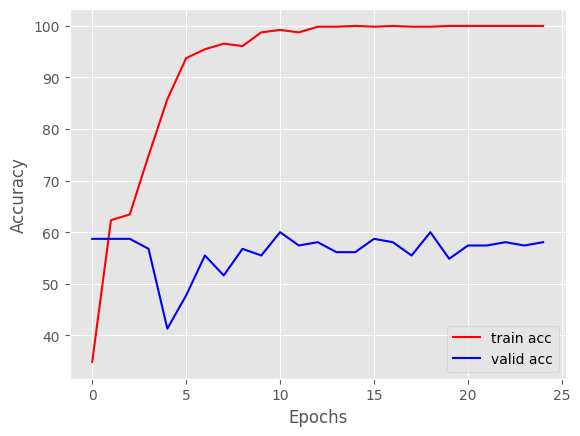

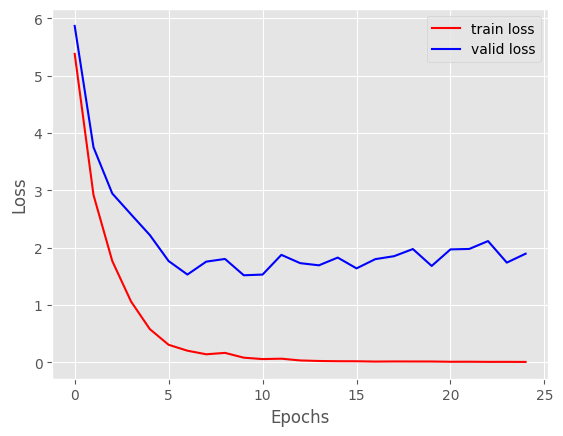

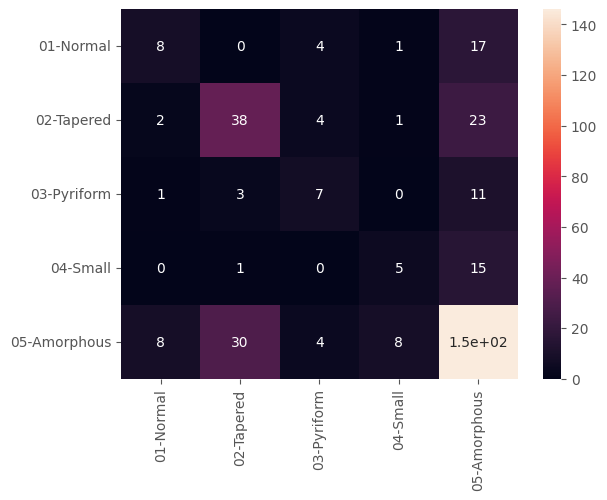

In [44]:
main_path = '/home/mcoronado/Escritorio/Codigo-Memoria/'
raw_dataset_name = 'raw_data'
dataset_name = 'data'

test_porcentage = 0.3
valid_porcentage = 0.7*0.2
train_porcentage = 0.7*0.8

image_dimention = (35,35)
batch_size = 64
learning_rate = 0.00001
epochs = 25

create_dataset(path_expertAnotations = main_path+'Data-set/PA-expert-annotations.txt', 
              path_partialImages = main_path+'Data-set/Partial-Agreement-Images/',
              dest_path = main_path+'Data-set',
              dataset_name = raw_dataset_name)

create_train_valid_test(origin_path=main_path+'Data-set/'+raw_dataset_name,
                        dest_path=main_path+'Data-set/',
                        dataset_name = dataset_name,
                        porcentages = [test_porcentage,valid_porcentage,train_porcentage])

dataset_path = main_path+'Data-set/'+dataset_name

train_loader, valid_loader, test_loader = load_data_pytorch_format( dataset_path, batch_size, image_dimention)

model = models.resnet18()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

process_model( model, epochs, train_loader, valid_loader, test_loader, optimizer, criterion )


In [32]:
#### OLD
# training
def train(model, trainloader, optimizer, criterion, device):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # forward pass
        outputs = model(image)
        # calculate the loss
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # backpropagation
        loss.backward()
        # update the optimizer parameters
        optimizer.step()
    
    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

# validation
def validate(model, validLoader, criterion, device):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(validLoader), total=len(validLoader)):
            counter += 1
            
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # forward pass
            outputs = model(image)
            # calculate the loss
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
        
    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(validLoader.dataset))
    return epoch_loss, epoch_acc



In [53]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime


model = models.resnet18()
device = ('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to('cpu')

# optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# loss function
loss_fn = nn.CrossEntropyLoss()

train_loader, valid_loader, test_loader = load_data_pytorch_format( dataset_path, batch_size, image_dimention )



# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 10

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer,train_loader)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(valid_loader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1


EPOCH 1:
LOSS train 0.0 valid 19.319379806518555
EPOCH 2:
LOSS train 0.0 valid 1.8944272994995117
EPOCH 3:
LOSS train 0.0 valid 1.3403593301773071
EPOCH 4:
LOSS train 0.0 valid 1.2215019464492798
EPOCH 5:
LOSS train 0.0 valid 1.3198930025100708
EPOCH 6:
LOSS train 0.0 valid 1.0202821493148804
EPOCH 7:
LOSS train 0.0 valid 1.4379658699035645
EPOCH 8:
LOSS train 0.0 valid 1.0351909399032593
EPOCH 9:
LOSS train 0.0 valid 1.2379870414733887
EPOCH 10:
LOSS train 0.0 valid 2.0369811058044434
